In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials


import utils

seed = 7
np.random.seed(seed)

Using Theano backend.


In [85]:
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adamax
import pandas as pd


class KerasModel(object):
    def __init__(self,
                 var_num,
                 epochs=70,
                 learn_rate=0.1,
                 config=None,
                 batch_size=512,
                 verbose=0,
                 validation_split=0.2,
                 loss="binary_crossentropy"):

        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.validation_split = validation_split
        
        self.model = Sequential()
        model = self.model
        
        if config is None:
            config =[(var_num, 0.0)]
        else:
            config = config.copy()
            
        n, dp = config.pop(0)

        model.add(Dense(n, input_dim=var_num, kernel_initializer='uniform'))
        model.add(LeakyReLU())
        if 0 < dp < 1:
            model.add(Dropout(dp))
        
        while config:
            n, dp = config.pop(0)
            model.add(Dense(n, kernel_initializer='uniform'))
            model.add(LeakyReLU())
            if 0 < dp < 1:
                model.add(Dropout(dp))


        model.add(Dense(1, activation='sigmoid'))
        opt = Adamax(lr=learn_rate)

        model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])


    def fit(self, X, y, sample_weight=None, callbacks=[]):
        process_X = X.values if hasattr(X, 'iloc') else X
        process_y = y
        return self.model.fit(process_X, process_y, batch_size=self.batch_size,
                       epochs=self.epochs, verbose=self.verbose,
                       sample_weight=sample_weight,
                       callbacks=callbacks,
                       validation_split=self.validation_split,
                       shuffle=True)

    def predict_proba(self, X):
        process_x = X.values if hasattr(X, 'iloc') else X
        result  = self.model.predict(process_x)
        classone_probs = result
        classzero_probs = 1.0 - classone_probs
        return np.hstack((classzero_probs, classone_probs))
#         return result
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_history(history):
    # list all data in history
    print(history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(13,7))
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(13,7))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [86]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train)
test = utils.clean_data(test)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

ccc = ['age', 'age_group', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'BMI', 'MAP']
def new_cols(data):    
    for col1 in ccc:
        data[col1 + '_log'] = np.log(data[col1] + 1.1)
        for col2 in ccc:
            data['%s_mul_%s' % (col1, col2)] = data[col1] * data[col2]
            data['%s_mul_log_%s' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
            data['%s_div_log_%s' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 1)

            if col2 == col1:
                continue

            data['%s_div_%s' % (col1, col2)] = data[col1] / (data[col2] + 1)

new_cols(X_train)
new_cols(X_test)

use_columns = [
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
# "gluc",
# "active_fair",
"smoke_restored",
"alco_restored",
"active_restored",
"height_mul_log_gluc",
"BMI",
"age_group",
# "cholesterol_div_log_age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
# "age_group_mul_log_ap_lo",
]

# scale_cols=[
# "height",
# "weight",
# "ap_hi",
# "ap_lo",
# "cholesterol",
# "height_mul_log_gluc",
# "BMI",
# "age_group",
# "cholesterol_div_log_gluc",
# "gluc_mul_log_age",
# ]

X_train = X_train[use_columns]
X_test = X_test[use_columns]

X = pd.concat((X_train,X_test), axis=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [88]:
loo = pd.read_csv('LOO_results.csv', sep=',', index_col='index')
loo = loo.sort_index()
strat = pd.qcut(loo, 20, labels=False).astype(str)
strat = np.hstack((strat, y_train.reshape((-1,1))))
strat =np.apply_along_axis(lambda d: str(d[0]) + '_' + str(d[1]), 1, strat)

In [91]:
def create(x1, x2):
    config = [(64,0.4), (32,0.13)]
    return KerasModel(var_num=len(use_columns),
                   epochs=200,
                   learn_rate=0.001,
                   config=config,
                   batch_size=1024,
                   verbose=0,
                   validation_split=0.0)
utils.execute_model(None,
              X_train,
              y_train,
              X_test,
              model_name="KERAS_1",
              n_splits=15,
              n_folds=10,
              stratification_groups=strat,
                    create_callback=create
#                     verbose=0
             )

# 10 folds logloss:
# [0.54090825419427224, 0.5420645621065534, 0.54378380512776359, 0.54325709548377732, 0.54468274415708207, 0.54029468759698118, 0.54352507074984413, 0.54685565419394933, 0.54020112643318119, 0.5436560250490583]
# mean: 0.542922902509
# std: 0.00198563910778
# 15 Splits logloss:
# [0.54265608754982464, 0.5426398031772558, 0.54246461801264168, 0.54209703243852014, 0.54228912460850554, 0.54312995340333625, 0.54068936993851369, 0.54211138891902133, 0.54264103206402314, 0.54233019546667738, 0.54060803921325573, 0.54195509464768254, 0.54225267909183383, 0.54273259723949285, 0.54274226783814705]
# mean: 0.542222618907
# std: 0.000684264682849


10 folds logloss:
[0.53990347404784012, 0.54152528495592211, 0.5407897688572072, 0.54155070634851377, 0.54266741693837506, 0.53909139828568575, 0.54128523894017933, 0.54348501804762972, 0.53940239741146678, 0.54218516820989704]
mean: 0.541188587204
std: 0.0013456147348
15 Splits logloss:
[0.54186104848843419, 0.54156578077289408, 0.54165550090235082, 0.5419327021073107, 0.54121673255582292, 0.54152776545938108, 0.54027087211999159, 0.54145890058820978, 0.54138547390475422, 0.5413866244562946, 0.54045266141290116, 0.54071247834605829, 0.54159479185357873, 0.5420846608074692, 0.54197919383290272]
mean: 0.541405679174
std: 0.000524698234619
KERAS_1 results saved!


(0.54118858720427165, 0.54140567917389026)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


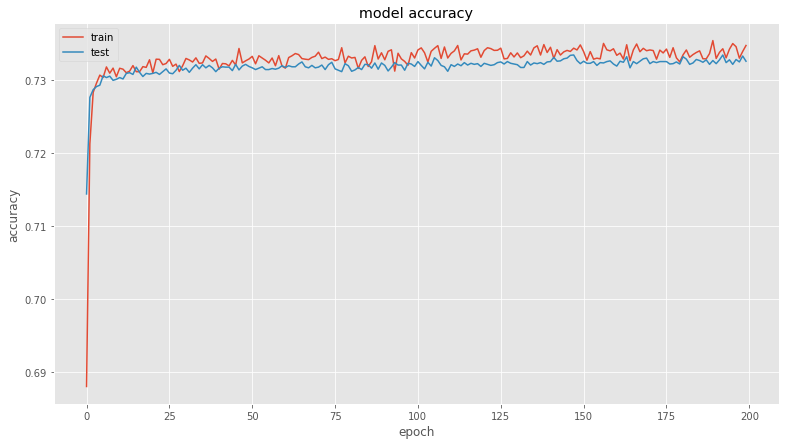

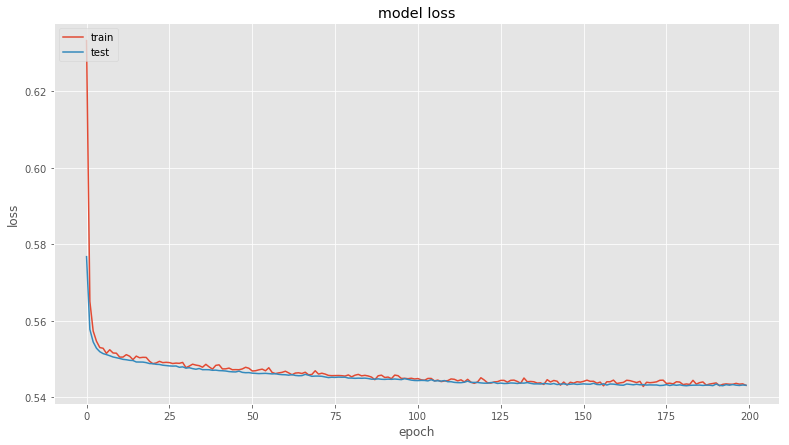

In [84]:
# Params testing:  {'batch_size': 256, 
# 'choice': {'dropout2': 0.4, 'layers': 'two', 'units2': 75},
# 'dropout1': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'units1': 128}
config = [(64,0.4), (32,0.13)]
model = KerasModel(var_num=len(use_columns), #!!!!!!!!!!!!!!!!!!!
                   epochs=200,
                   learn_rate=0.001,
                   config=config,
                   batch_size=1024,
                   verbose=0,
                   validation_split=0.3)
# model.fit_process(X_train, X_test, y_train)
history = model.fit(X_train, y_train).history
plot_history(history)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import random
from sklearn.metrics import log_loss, accuracy_score

kf = StratifiedKFold(n_splits=7, random_state=125, shuffle=True)

def objective2(dp1, dp2):
    global best_params, best_score
    np.random.seed(1205)
    random.seed(1205)

    accuracy = []
    for train_idx, test_idx in kf.split(X_train, y_train):
        config = [(60,dp1),(30,dp2)]
        clf = KerasModel(cols,
                       epochs=100,
                       learn_rate=0.01,
                       config=config,
                       batch_size=128,
                       verbose=0,
                       validation_split=0.2,
                   loss='categorical_crossentropy')
        clf.fit_process(X_train, X_test, y_train)
        clf.fit(X_train.iloc[train_idx], y_train[train_idx])
        result = clf.predict(X_train.iloc[test_idx])
        accuracy.append(accuracy_score(y_train[test_idx], result))

    score = np.mean(accuracy)
    std = np.std(accuracy)
    print(dp1,dp2,"Score:", score, std)

    
for i in np.arange(0,1,0.1).tolist():
    for j in np.arange(0,1,0.1).tolist():
        objective2(i,j)

In [18]:
# Params testing:  
#     {'batch_size': 128, 'choice':
#      {'dropout2': 0.6, 'layers': 'two', 'units2': 30},
#      'dropout1': 0.1, 'epochs': 100, 'learning_rate': 0.01, 'loss': 'categorical_crossentropy', 'units1': 90}

def cr_keros():
    config = [(90,0.2),(30,0.06)]
    clf = KerasModel(cols,
                       epochs=70,
                       learn_rate=0.001,
                       config=config,
                       batch_size=256,
                       verbose=0,
                       validation_split=0.2,
                   loss='categorical_crossentropy')
    clf.fit_process(X_train, X_test, y_train)
    return clf

In [21]:
# utils.execute_model(None, X_train, y_train, X_test, model_name="Keros_proto", create_callback=cr_keros)
utils.execute_nfolds(None, X_train, y_train, model_name="Keros_proto", create_callback=cr_keros)

Accuracy:
[0.57044673539518898, 0.55899198167239406, 0.55670103092783507, 0.54295532646048106, 0.5521191294387171, 0.56930126002290948, 0.54295532646048106, 0.52920962199312716, 0.53951890034364258, 0.54753722794959914, 0.58762886597938147, 0.54295532646048106, 0.54868270332187863, 0.54639175257731953, 0.52462772050400919, 0.54639175257731953, 0.53951890034364258, 0.5532646048109966, 0.55555555555555558, 0.56357388316151202, 0.56357388316151202, 0.5532646048109966, 0.5223367697594502, 0.55441008018327609, 0.55555555555555558, 0.54066437571592207, 0.5670103092783505, 0.5532646048109966, 0.54066437571592207, 0.57617411225658643, 0.57044673539518898, 0.55555555555555558, 0.57044673539518898, 0.55441008018327609, 0.55097365406643761, 0.56586483390607101, 0.56013745704467355, 0.5830469644902635, 0.54982817869415812, 0.53035509736540665, 0.52806414662084766, 0.54639175257731953, 0.5372279495990836, 0.56357388316151202, 0.55097365406643761, 0.54180985108820157, 0.56357388316151202, 0.57044673

In [48]:
space = {
'choice':
    hp.choice('num_layers',
    [
#         {'layers':'one',

#         },
        {'layers':'two',
          'units2': hp.choice('units2', [8, 16, 32, 64, 75, 90, 105, 128, 256]),
          'dropout2': hp.choice('dropout2', [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
                    
        }
    ]),
    
    'units1': hp.choice('units1', [8, 16, 32, 64, 75, 90, 105, 128, 256]),
    'dropout1': hp.choice('dropout1', [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
    
    'batch_size' : hp.choice('batch_size', [128, 256, 512]),

    'epochs' :  100,
#     'loss': hp.choice('loss', ['categorical_crossentropy', 'mean_squared_error', 'mean_squared_logarithmic_error']), # 
    'learning_rate': 0.01, #hp.choice('learning_rate', [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]),
         
}

In [52]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import random
from sklearn.metrics import log_loss, accuracy_score

best_params = None
best_score = 1000000
kf = StratifiedKFold(n_splits=7, random_state=11111, shuffle=True)

def objective(params):
    global best_params, best_score
    print ('\n ')
    print ('Params testing: ', params)
    
    config = [(params['units1'],params['dropout1'])]
    if params['choice']['layers'] == 'two':
        config.append((params['choice']['units2'], params['choice']['dropout2']))
    
    nn_params = dict(
                 epochs=params['epochs'],
                 learn_rate=params['learning_rate'],
                 config=config,
                 batch_size=params['batch_size'],
#                  loss=params['loss'],
                 )

#     model = KerasModel(cols, **nn_params)
#     model.fit_process(X_train, X_test, y_train)
    
    np.random.seed(1205)
    random.seed(1205)
    
#     KerasModel(var_num=len(use_columns), #!!!!!!!!!!!!!!!!!!!
#                    epochs=100,
#                    learn_rate=0.01,
#                    config=config,
#                    batch_size=256,
#                    verbose=0,
#                    validation_split=0.2)

    accuracy = []
    for train_idx, test_idx in kf.split(X_train, y_train):
        clf = KerasModel(var_num=len(use_columns), **nn_params)
#         clf.fit_process(X_train, X_test, y_train)
#         clf.fit(X_train.iloc[train_idx], y_train[train_idx])
        clf.fit(X_train[train_idx], y_train[train_idx])
        result = clf.predict_proba(X_train[test_idx])[:, 1]
        accuracy.append(log_loss(y_train[test_idx], result))

    score2 = np.mean(accuracy)
    std = np.std(accuracy)
    
    score = (round(score2, 4) * 10000 - std)
    
    if score < best_score:
        best_score = score
        best_params = params
        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        print('New best params with score:', score)
    
    print("Score:", score2)
    print("Std:", std)
 
    return {'loss': score, 'status': STATUS_OK}

In [53]:
trials = Trials()

best = fmin(objective, space, algo=tpe.suggest, trials=trials, max_evals=1000)

print('FINISHED!================')
print(best)


 
Params testing:  {'batch_size': 128, 'choice': {'dropout2': 0.8, 'layers': 'two', 'units2': 16}, 'dropout1': 0.7, 'epochs': 100, 'learning_rate': 0.01, 'units1': 90}
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
New best params with score: 5537.99647976
Score: 0.553767029313
Std: 0.00352023983451

 
Params testing:  {'batch_size': 512, 'choice': {'dropout2': 0.6, 'layers': 'two', 'units2': 105}, 'dropout1': 0.6, 'epochs': 100, 'learning_rate': 0.01, 'units1': 90}
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
New best params with score: 5438.99773539
Score: 0.543901494359
Std: 0.00226461319265

 
Params testing:  {'batch_size': 256, 'choice': {'dropout2': 0.4, 'layers': 'two', 'units2': 75}, 'dropout1': 0.5, 'epochs': 100, 'learning_rate': 0.01, 'units1': 128}
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
New best params with score: 5421.99715784
Score: 0.542192950129
Std: 0.00284215838985

 
Params testing:  {'batch_size': 256, 'choice': {'dropout2': 0.5, 'layers': 'two', '

KeyboardInterrupt: 

In [ ]:
Params testing:  {'batch_size': 256, 'choice': {'dropout2': 0.6, 'layers': 'two', 'units2': 135}, 'dropout1': 0.5, 'epochs': 70, 'learning_rate': 0.01, 'loss': 'mean_squared_error', 'units1': 120}
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
New best params with score: -5701.98415097
Score: 0.570199308069
Std: 0.0158490291934
    
Params testing:  {'batch_size': 256, 'choice': {'dropout2': 0.3, 'layers': 'two', 'units2': 120}, 'dropout1': 0.2, 'epochs': 70, 'learning_rate': 0.02, 'loss': 'mean_squared_error', 'units1': 105}
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
New best params with score: -5701.97841617
Score: 0.570185563777
Std: 0.0215838348883
    
Params testing:  {'batch_size': 128, 'choice': {'dropout2': 0.6, 'layers': 'two', 'units2': 30}, 'dropout1': 0.1, 'epochs': 100, 'learning_rate': 0.01, 'loss': 'categorical_crossentropy', 'units1': 90}
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
New best params with score: -5694.9773857
Score: 0.569510138566
Std: 0.022614299518